In [144]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel

In [145]:
nest.ResetKernel()
dt = .1
#nest.resolution = 1.0
# Parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.


Text(0, 0.5, 'Amplitude')

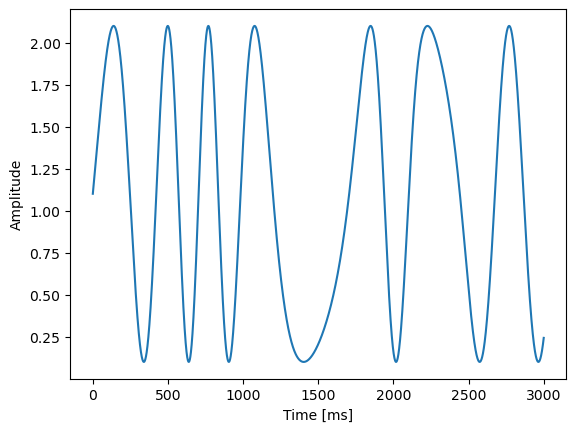

In [256]:
t_samples = np.arange(-100, 3500, 300)
freq_samples = (np.random.random(t_samples.shape) * 2.5 + 0.5)/100

t = np.arange(0, 3000, dt)+dt

dx = np.full_like(t, dt)       # Change in x

interpolation = interp1d(x_samples, freq_samples, kind='quadratic')
freq = interpolation(t)

x = (freq * dx ).cumsum()    # Cumsum freq * change in x

signal = np.sin(x)+1+dt

pl.plot(t, signal)
pl.xlabel('Time [ms]')
pl.ylabel("Amplitude")


In [252]:
print(len(signal))

30000


In [253]:
print(len(t))

30000


In [246]:
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

In [247]:
enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

In [258]:
step_generator = nest.Create('step_current_generator', nEnc)
amplitudes = np.zeros((nEnc, len(signal)))
for n in range(nEnc):
    amplitudes[n, :] = signal * tuning[n]
    enc_layer[n].set({'V_m': Vm0[n], 'V_th': thresholds[n]})
    #print(len(amplitudes[0]), len(t))
    step_generator[n].set({'amplitude_times': t, 'amplitude_values': amplitudes[n]})
    nest.Connect(step_generator[n], enc_layer[n])

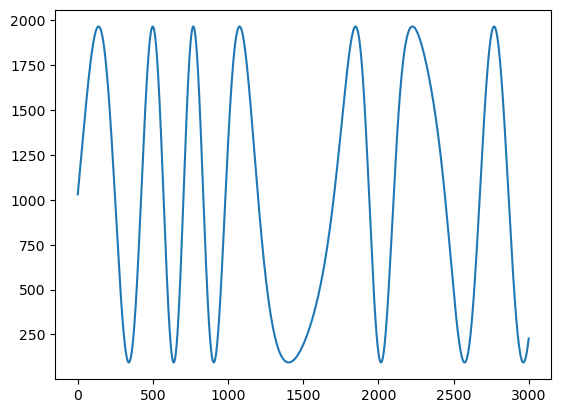

In [263]:
pl.plot(t, amplitudes[0])

In [264]:
len(amplitudes[0])

30000

In [268]:
enc_spks = nest.Create('spike_recorder')
nest.Connect(enc_layer, enc_spks)

In [266]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 200                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create spike detectors
spikes_e = nest.Create('spike_recorder')
# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

In [288]:
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

In [270]:
nest.Simulate(len(t))


Oct 19 10:20:59 NodeManager::prepare_nodes [Info]: 
    Preparing 4753 nodes for simulation.

Oct 19 10:20:59 MUSICManager::enter_runtime [Info]: 
    Entering MUSIC runtime with tick = 1 ms

Oct 19 10:20:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4753
    Simulation time (ms): 30000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 19 10:26:58 SimulationManager::run [Info]: 
    Simulation finished.


In [274]:
filter_tau = 20. # [ms]
num_threads = 8
t_stop = len(t)
enc_activity = enc_spks.events
enc_states = filter_spikes_parallel(enc_activity['times'], enc_activity['senders'], nEnc, t_start=0., 
                                    t_stop=t_stop, dt=dt, tau=filter_tau, n_processes=num_threads)


e_activity = spikes_e.events
# e_states = filter_spikes(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau)

# if you can use parallelization, it can be very useful here:
e_states = filter_spikes_parallel(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=t_stop, 
                                  dt=dt, tau=filter_tau, n_processes=num_threads)

Filtering SpikeTrains: 100%|████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  5.13it/s]


In [275]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal)
circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal)

print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

Encoding Layer: 
	- Capacity=3.7794888586551978e-06, MSE=1.6966977038387752
Main Circuit: 
	- Capacity=2.9245947605617484e-06, MSE=1.6969936402712522


In [278]:
len(e_states)

1000

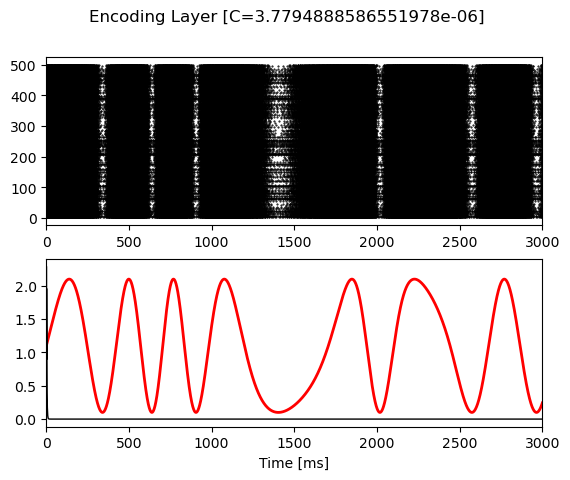

In [283]:
fig = pl.figure()
fig.suptitle('Encoding Layer [C={0}]'.format(str(enc_capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(enc_activity['times'], enc_activity['senders'], '.k', markersize=1)
ax11.set_xlim([0., len(t)/10])
ax12.plot(t, signal, 'r', linewidth=2)
ax12.plot(t, enc_estimate, 'k', linewidth=1)
ax12.set_xlabel(r'Time [ms]')
pl.show()

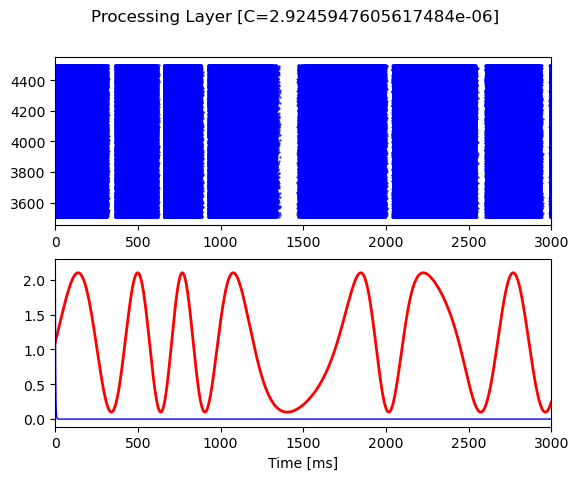

In [285]:
fig = pl.figure()
fig.suptitle('Processing Layer [C={0}]'.format(str(circ_capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(e_activity['times'], e_activity['senders'], '.b', markersize=1)
ax11.set_xlim([0., len(t)/10])
ax12.plot(t, signal, 'r', linewidth=2)
ax12.plot(t, circ_estimate, 'b', linewidth=1)
ax12.set_xlabel(r'Time [ms]')
pl.show()

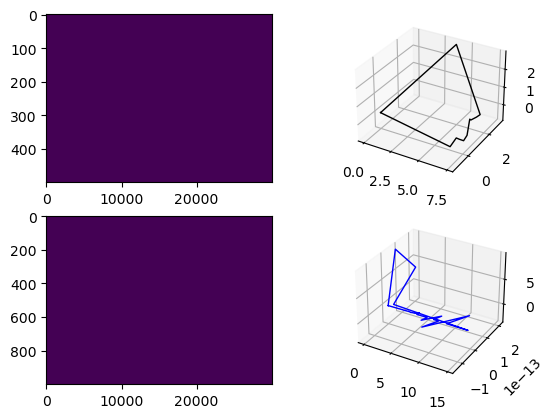

In [286]:
fig = pl.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(enc_states, aspect='auto')
ax2 = fig.add_subplot(222, projection='3d')
pca_fit_enc = PCA(n_components=np.shape(enc_states)[0])
X_enc = pca_fit_enc.fit_transform(enc_states.T)
ax2.plot(X_enc[:, 0], X_enc[:, 1], X_enc[:, 2], color='k', lw=1)
ax3 = fig.add_subplot(223)
ax3.imshow(e_states, aspect='auto')
ax4 = fig.add_subplot(224, projection='3d')
pca_fit_enc = PCA(n_components=np.shape(e_states)[0])
X_cir = pca_fit_enc.fit_transform(e_states.T)
ax4.plot(X_cir[:, 0], X_cir[:, 1], X_cir[:, 2], color='b', lw=1)
pl.show()

In [ ]:
max_lag = 100.  # [ms] in this example
step_lag = 10.  # [ms] - if != dt (index the time axis)
time_lags = np.arange(0., max_lag, step_lag)
indices = [np.where(idx == time_vector)[0][0] for idx in time_lags]

encoder_capacity = []
circuit_capacity = []

for idx, lag in zip(indices, time_lags):

	# shift the target signal
	if idx > 0:
		shifted_signal = signal[:-idx]
	else:
		shifted_signal = signal

	# shift the population states
	enc_st = enc_states[:, idx:]
	circ_st = e_states[:, idx:]

	# compute capacity
	enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
	circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)

	print("Lag = {0} ms".format(str(lag)))
	print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
	print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

	encoder_capacity.append(enc_capacity)
	circuit_capacity.append(circ_capacity)

fig = pl.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time_lags, encoder_capacity)
ax2.plot(time_lags, circuit_capacity)

pl.show()

print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))

NameError: name 'time_vector' is not defined